In [1]:
import os
import sys
sys.path.append('../')
import pandas as pd
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_root = '/mnt/data2/mtseng/dataset/SeNSE/TCH_processed/raw'
subject_id = 'c1s01'

In [3]:
df = pd.read_pickle(os.path.join(data_root, '{}.pkl'.format(subject_id)))
print(df.head())
print(df.shape)

                     Time  EcgWaveform  HR  HRConfidence  ECGNoise  \
0 2022-06-08 13:32:45.441          179  65             0       0.0   
1 2022-06-08 13:32:45.445          179  65             0       0.0   
2 2022-06-08 13:32:45.449          179  65             0       0.0   
3 2022-06-08 13:32:45.453          179  65             0       0.0   
4 2022-06-08 13:32:45.457          179  65             0       0.0   

            Timestamp  glucose    Index  
0 2022-06-08 13:33:48    132.0  19134.0  
1 2022-06-08 13:33:48    132.0  19134.0  
2 2022-06-08 13:33:48    132.0  19134.0  
3 2022-06-08 13:33:48    132.0  19134.0  
4 2022-06-08 13:33:48    132.0  19134.0  
(200691385, 8)


### Get CGM segments

In [4]:
# group by Index
cgm_segments = df.groupby('Index')
cgm_segments = [cgm_segments.get_group(x) for x in cgm_segments.groups]

### Get the ECG beat within a CGM segment

In [5]:
def process_cgm_segment(cgm_df, fs=250):
    beat_data = []
    glucose = cgm_df["glucose"].values.mean()
    Timestamp = cgm_df["Timestamp"].values[0]
    _cgm_idx = cgm_df["Index"].values[0]

    ecg = cgm_df["EcgWaveform"].values
    ecg_clean = nk.ecg_clean(ecg, sampling_rate=fs)
    _, rpeaks = nk.ecg_peaks(ecg_clean, sampling_rate=fs, correct_artifacts=True)

    r_peaks = np.unique(rpeaks['ECG_R_Peaks'])


    Times = cgm_df["Time"].values
    cgm_start_idx = cgm_df.index[0]
    for i in range(1, len(r_peaks)):
        rr = Times[r_peaks[i]] - Times[r_peaks[i-1]]
        Time = Times[r_peaks[i]]
        
        start_t = Time - (1/3) * rr
        end_t = Time + (1/2) * rr

        beat_window = cgm_df[(cgm_df["Time"] > start_t) & (cgm_df["Time"] < end_t)]
        beat_start_idx = beat_window.index[0]
        r_peak_idx = cgm_start_idx + r_peaks[i] - beat_start_idx

        avg_HRConfidence = beat_window["HRConfidence"].values.mean()
        avg_ECGNoise = beat_window["ECGNoise"].values.mean()

        beat_data.append({
            "Time": beat_window["Time"].values,
            "EcgWaveform": beat_window["EcgWaveform"].values,
            "HR": beat_window["HR"].values,
            "glucose": glucose,
            "CGM_idx": _cgm_idx,
            'HRConfidence': avg_HRConfidence,
            'ECGNoise': avg_ECGNoise,
            'r_peak': r_peak_idx,
            'Timestamp': Timestamp,
        })
    
    return np.array(ecg), glucose, Times, beat_data

### Demo

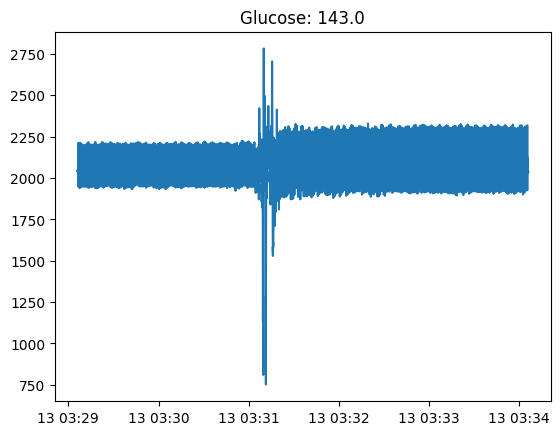

In [6]:
CGM_segment_idx = 1000
cgm_segment = cgm_segments[CGM_segment_idx]
cgm_ecgs, glucose, Times, beat_data = process_cgm_segment(cgm_segment)

plt.plot(Times, cgm_ecgs)
plt.title('Glucose: {}'.format(glucose))
plt.show()

Number of beats: 331
Number of clean beats: 287


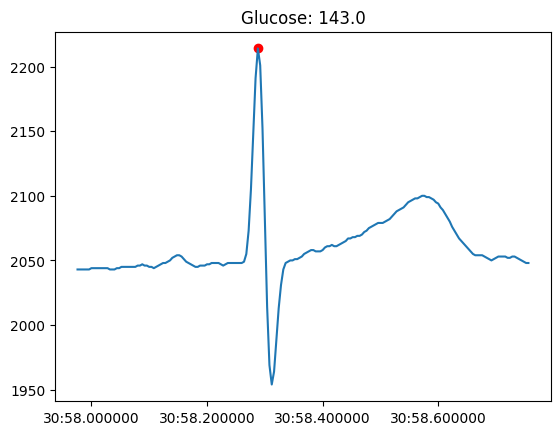

In [7]:
# plot one beat
num_clean_beats = 0
clean_indices = []
for i, b in enumerate(beat_data):
    if b['ECGNoise'] < 0.001 and b['HRConfidence'] >= 100:
        num_clean_beats += 1
        clean_indices.append(i)

print('Number of beats: {}'.format(len(beat_data)))
print('Number of clean beats: {}'.format(num_clean_beats))
if num_clean_beats > 0:
    beat_idx = np.random.choice(clean_indices)
    beat = beat_data[beat_idx]
    plt.plot(beat['Time'], beat['EcgWaveform'])
    plt.scatter(beat['Time'][beat['r_peak']], beat['EcgWaveform'][beat['r_peak']], c='r')
    plt.title('Glucose: {}'.format(glucose))
    plt.show()